In [11]:
import glob
import numpy
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme

In [12]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load

In [13]:
dataset = ""

In [14]:
FluxesByOrganism = {}
for c in ["nonIBD","IBD"]:
    FluxesByOrganism[c] = pandas.read_csv("./datasets/3.6.TotalFluxes_{}{}.csv".format(c,dataset),index_col=0).dropna(1) / 1e3 # Converted mmol to mol

/tmp/ipykernel_1318490/555994926.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  FluxesByOrganism[c] = pandas.read_csv("./datasets/3.6.TotalFluxes_{}{}.csv".format(c,dataset),index_col=0).dropna(1) / 1e3 # Converted mmol to mol
/tmp/ipykernel_1318490/555994926.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  FluxesByOrganism[c] = pandas.read_csv("./datasets/3.6.TotalFluxes_{}{}.csv".format(c,dataset),index_col=0).dropna(1) / 1e3 # Converted mmol to mol


In [15]:
def save_dict_of_dataframes_to_excel(dict_of_dataframes, excel_filename):
    """
    Save a dictionary of dataframes into an Excel worksheet, with each dataframe in a separate sheet.

    Parameters:
    - dict_of_dataframes (dict): A dictionary where keys are sheet names and values are dataframes.
    - excel_filename (str): The name of the Excel file to be created.

    Example:
    ```python
    dataframes_dict = {'Sheet1': df1, 'Sheet2': df2, 'Sheet3': df3}
    save_dict_of_dataframes_to_excel(dataframes_dict, 'output.xlsx')
    ```
    """
    with pandas.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        for sheet_name, dataframe in dict_of_dataframes.items():
            dataframe.to_excel(writer, sheet_name=sheet_name, index=True)


In [16]:
Producing = {k:v.copy() for k,v in FluxesByOrganism.items()}
for k,v in Producing.items():
    v[v<1e-16] = 0
    v = v[v.any(axis=1)]

In [17]:
Consuming = {k:v.copy() for k,v in FluxesByOrganism.items()}
for k,v in Consuming.items():
    v[v>-1e-16] = 0
    v = v[v.any(axis=1)]
Consuming["nonIBD"] = Consuming["nonIBD"].abs()
Consuming["IBD"] = Consuming["IBD"].abs()

In [18]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t').drop("NCBI Taxonomy ID",axis=1)
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]

In [19]:
taxonomy[taxonomy["Genus"] == "Bifidobacterium"]

,Strain,Species,Genus,Family,Order,Class,Phylum,Kingdom
MicrobeID,,,,,,,,
Bifidobacterium_adolescentis_ATCC_15703,Bifidobacterium adolescentis ATCC 15703,Bifidobacterium adolescentis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_angulatum_DSM_20098,Bifidobacterium angulatum DSM 20098 = JCM 7096,Bifidobacterium angulatum,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_AD011,Bifidobacterium animalis subsp. lactis AD011,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_BB_12,Bifidobacterium animalis subsp. lactis BB-12,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_Bi_07,Bifidobacterium animalis subsp. lactis Bi-07,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_Bl_04_ATCC_SD5219,Bifidobacterium animalis subsp. lactis Bl-04,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_CNCM_I_2494,Bifidobacterium animalis subsp. lactis CNCM I-...,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_DSM_10140,Bifidobacterium animalis subsp. lactis DSM 10140,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_V9,Bifidobacterium animalis subsp. lactis V9,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria


In [20]:
def get_delta(df,Taxa):
    FluxByOrg_Annotated = pandas.concat([df,taxonomy],axis=1).dropna()
    FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
    # FluxByGenus = FluxByGenus[FluxByGenus>0].dropna()
    Delta = (FluxByGenus["IBD"] - FluxByGenus["nonIBD"])
    return Delta

def get_delta_met(met,df):
    FluxByOrg = pandas.DataFrame()
    for k,v in df.items():
        if met not in v.index:
            FluxByOrg[k] = 0
            continue
        FluxByOrg[k] = v.loc[met]
    return get_delta(FluxByOrg,"Genus")

### Flux by met

In [22]:
mets = set(FluxesByOrganism["nonIBD"].index.to_list() + FluxesByOrganism["IBD"].index.to_list())

In [83]:
Deltas = {}

In [84]:
Delta = pandas.DataFrame()
for m in mets:
    Delta[m] = get_delta_met(m,FluxesByOrganism)
Delta = Delta.fillna(0.)
Deltas["total"] = Delta

/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOr

<Axes: >

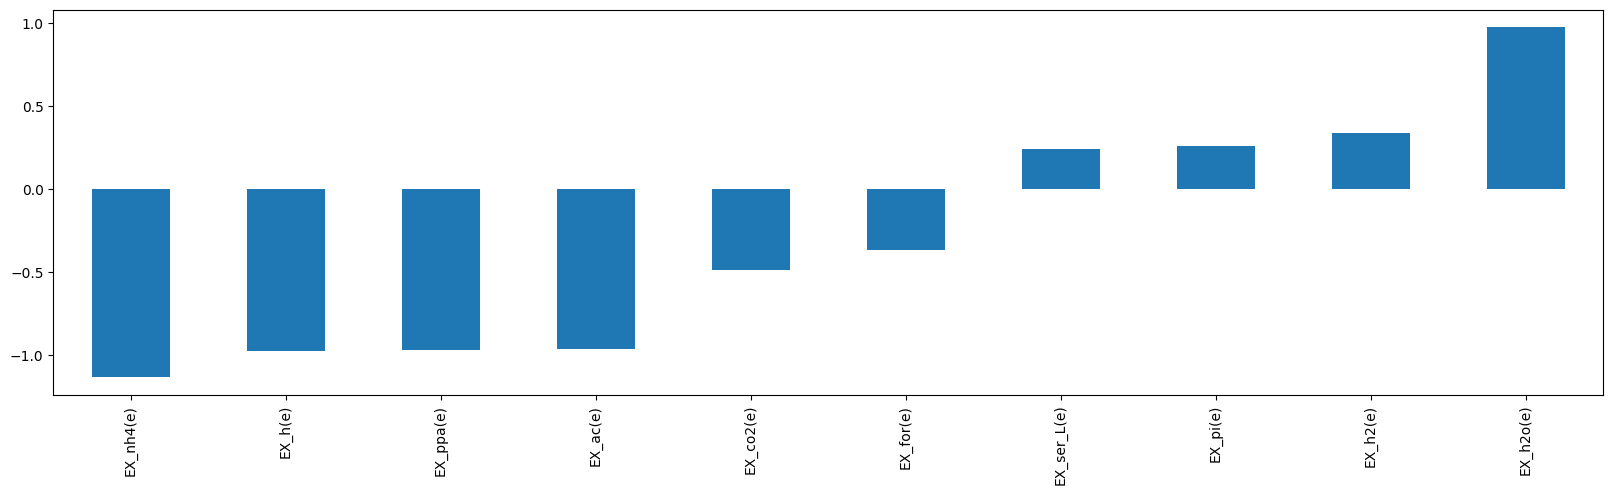

In [85]:
tmp = Deltas["total"].sum()
(tmp[tmp.abs()>0.1]).sort_values().plot.bar(figsize=(20,5))

In [86]:
mets = Deltas["total"].sum().abs().sort_values(ascending=False).index
mets

Index(['EX_nh4(e)', 'EX_h(e)', 'EX_h2o(e)', 'EX_ppa(e)', 'EX_ac(e)',
       'EX_co2(e)', 'EX_for(e)', 'EX_h2(e)', 'EX_pi(e)', 'EX_ser_L(e)'],
      dtype='object')

In [87]:
Delta = pandas.DataFrame()
for m in mets:
    Delta[m] = get_delta_met(m,Producing)
Delta = Delta.fillna(0.)
Deltas["producing"] = Delta

/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOr

In [88]:
Delta = pandas.DataFrame()
for m in mets:
    Delta[m] = get_delta_met(m,Consuming)
Delta = Delta.fillna(0.)
Deltas["consuming"] = Delta

/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_1318490/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOr

In [89]:
def add_total(df):
    df = df.T
    df["Total"] = df.sum(axis=1)
    df[df.abs().sort_values(axis=0,by="Total",ascending=False).columns]
    return df.T
SaveDeltas = {k:add_total(df) for k,df in Deltas.items()}
save_dict_of_dataframes_to_excel(SaveDeltas,"SupplementaryFile-Deltas.xlsx")

### Heatmap

In [30]:
mets = Deltas["total"].sum().abs().sort_values(ascending=False).head(10).index
mets

Index(['EX_nh4(e)', 'EX_h(e)', 'EX_h2o(e)', 'EX_ppa(e)', 'EX_ac(e)',
       'EX_co2(e)', 'EX_for(e)', 'EX_h2(e)', 'EX_pi(e)', 'EX_ser_L(e)'],
      dtype='object')

In [31]:
Deltas["total"].sum().sort_values(ascending=False).head(10)

EX_h2o(e)      0.974894
EX_h2(e)       0.334135
EX_pi(e)       0.256567
EX_ser_L(e)    0.241260
EX_acgam(e)    0.218991
EX_but(e)      0.215469
EX_uri(e)      0.136124
EX_acnam(e)    0.103068
EX_pydx(e)     0.102382
EX_2obut(e)    0.078680
dtype: float64

In [32]:
Totals = pandas.DataFrame()

Totals["Producing-nonIBD"] = Producing["nonIBD"].sum(1)
Totals["Consuming-nonIBD"] = Consuming["nonIBD"].sum(1)

Totals["Producing-IBD"] = Producing["IBD"].sum(1)
Totals["Consuming-IBD"] = Consuming["IBD"].sum(1)

Totals.fillna(0.)

Totals["nonIBD"] = Totals["Producing-nonIBD"] - Totals["Consuming-nonIBD"]
Totals["IBD"] = Totals["Producing-IBD"] - Totals["Consuming-IBD"]
Totals["Net"] = Totals["IBD"] - Totals["nonIBD"]

Totals = Totals[["nonIBD","IBD","Net"]].T[list(set(mets) & set(Totals.index))]
Totals

,EX_pi(e),EX_h2o(e),EX_ser_L(e),EX_for(e),EX_nh4(e),EX_h(e),EX_ac(e),EX_co2(e),EX_h2(e),EX_ppa(e)
nonIBD,-0.259969,-2.905490,-0.570681,2.934210,2.325088,4.840771,3.301429,1.007886,0.318217,1.486348
IBD,-0.003402,-1.930596,-0.329421,2.563669,1.189920,3.865110,2.334243,0.519904,0.652352,0.514943
Net,0.256567,0.974894,0.241260,-0.370541,-1.135168,-0.975661,-0.967186,-0.487982,0.334135,-0.971406


In [33]:
cutoff = 0.01

In [34]:
tmp = Deltas["producing"].copy()
tmp[tmp.abs()<cutoff] = 0
TotalsProducing = tmp[tmp.any(axis=1)]
TotalsProducing

,EX_nh4(e),EX_h(e),EX_h2o(e),EX_ppa(e),EX_ac(e),EX_co2(e),EX_for(e),EX_h2(e),EX_pi(e),EX_ser_L(e),...,EX_dhcinnm(e),EX_starch1200(e),EX_phppa(e),EX_5aptn(e),EX_crn(e),EX_tchola(e),EX_tdchola(e),EX_glygn2(e),EX_Lcyst(e),EX_bglc(e)
Genus,,,,,,,,,,,,,,,,,,,,,
Akkermansia,0.012683,0.027828,0.000000,0.000000,0.019060,0.000000,0.024378,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alistipes,0.000000,0.012282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bacteroides,-0.705256,-1.128213,0.000000,-0.315533,-0.956551,-0.244695,-0.728539,-0.063757,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dorea,0.000000,0.020831,0.000000,0.000000,0.016068,0.000000,0.016669,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Enterocloster,0.000000,0.122660,0.000000,0.000000,0.059014,0.000000,0.041985,0.000000,0.014723,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Escherichia,0.040918,0.053930,0.000000,0.000000,0.087223,0.025854,0.041099,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Faecalibacterium,-0.194706,-0.350185,0.000000,0.000000,-0.422213,-0.142291,-0.304431,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Holdemania,0.012023,0.025245,0.000000,0.000000,0.011967,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lachnoclostridium,0.000000,0.000000,0.000000,0.000000,0.034289,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
tmp = Deltas["consuming"].copy()
tmp[tmp.abs()<cutoff] = 0
TotalsConsuming = tmp[tmp.any(axis=1)]
TotalsConsuming

,EX_nh4(e),EX_h(e),EX_h2o(e),EX_ppa(e),EX_ac(e),EX_co2(e),EX_for(e),EX_h2(e),EX_pi(e),EX_ser_L(e),...,EX_dhcinnm(e),EX_starch1200(e),EX_phppa(e),EX_5aptn(e),EX_crn(e),EX_tchola(e),EX_tdchola(e),EX_glygn2(e),EX_Lcyst(e),EX_bglc(e)
Genus,,,,,,,,,,,,,,,,,,,,,
Akkermansia,0.0,0.000000,0.017911,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bacteroides,0.0,-0.010387,-0.805507,0.0,0.0,0.0,0.0,-0.014149,-0.102635,-0.194390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dialister,0.0,0.000000,-0.015307,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Enterocloster,0.0,0.000000,0.051794,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Escherichia,0.0,0.000000,0.031092,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Faecalibacterium,0.0,0.000000,-0.350893,0.0,0.0,0.0,0.0,0.000000,-0.028929,-0.074749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Holdemania,0.0,0.000000,0.010226,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lachnospira,0.0,0.000000,0.126734,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Phocaeicola,0.0,0.000000,-0.621206,0.0,0.0,0.0,0.0,0.000000,-0.091967,-0.076433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'Change in ')

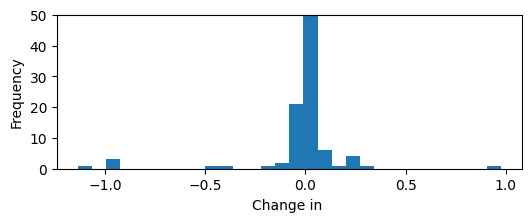

In [36]:
Deltas["total"].sum().sort_values().plot.hist(bins=30,figsize=(6,2))
plt.ylim([0,50])
plt.xlabel("Change in ")

### Plots

In [42]:
plt.rcParams['svg.fonttype'] = 'none'

In [43]:
# lengths = Totals.shape[0],TotalsProducing.shape[0],TotalsConsuming.shape[0]
lengths = TotalsProducing.shape[0],TotalsConsuming.shape[0]

/tmp/ipykernel_1318490/2989823698.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()
/tmp/ipykernel_1318490/2989823698.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()
/tmp/ipykernel_1318490/2989823698.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu').copy()


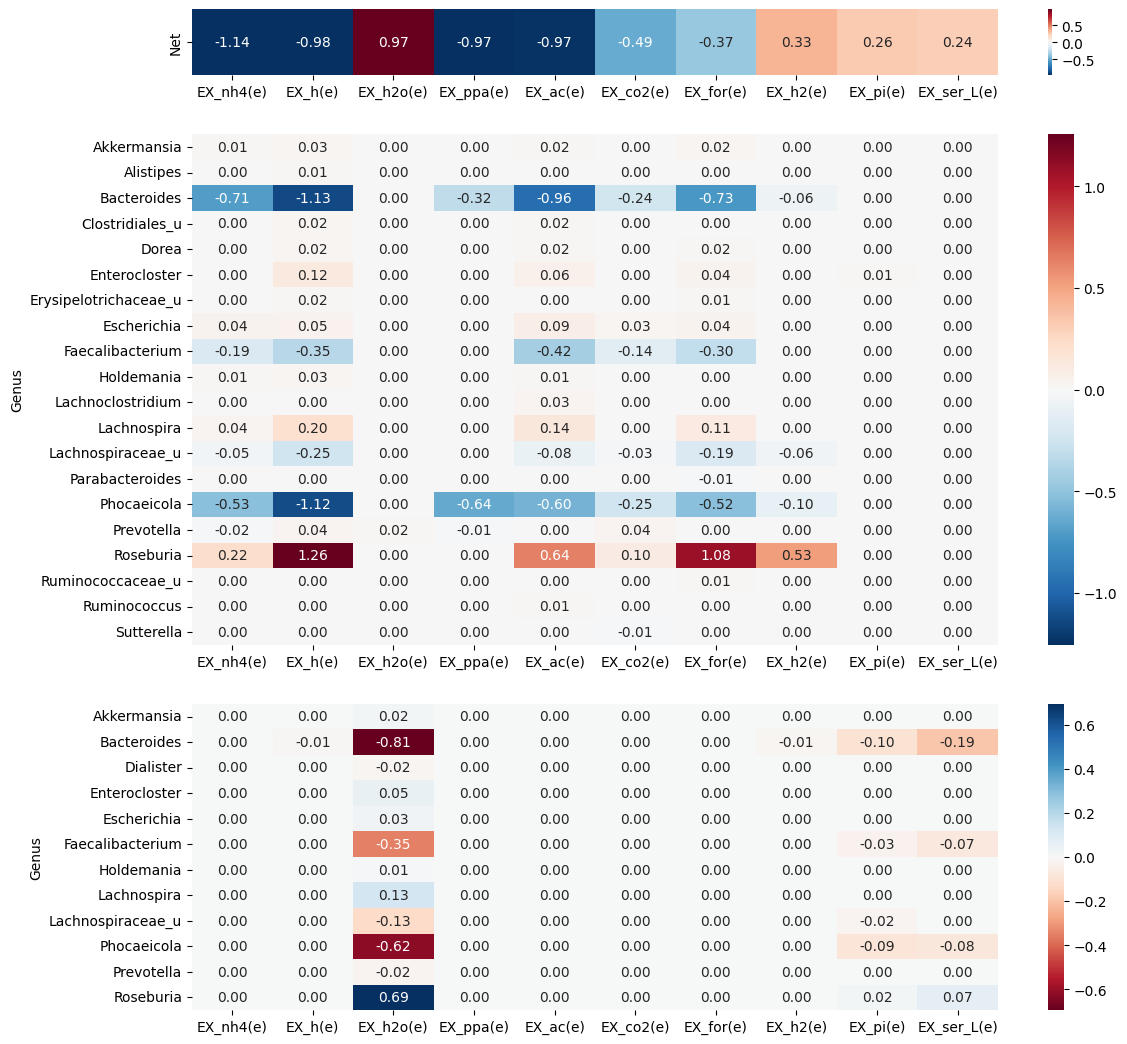

In [64]:
topratio = 0.075
rest = 1 - topratio
fig,ax = plt.subplots(3,1,gridspec_kw={"height_ratios": [topratio, rest*(lengths[0]/sum(lengths)),rest*(lengths[1]/sum(lengths))]},figsize=(13,13))

cmap_df = Totals[mets].copy().loc[["Net"]]
cmap = plt.cm.get_cmap('RdBu_r').copy()
# cmap.set_under('white')
vmin,vmax = -cmap_df.max().max(),cmap_df.max().max()
cmap = sns.heatmap(cmap_df,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".2f",
               cmap=cmap,
               ax=ax[0]
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )

cmap_df = TotalsProducing[mets].copy()
cmap_df.index = cmap_df.reset_index()["Genus"].apply(lambda x : x.replace("unclassified ","")+"_u" if "unclassified" in x else x)
cmap_df = cmap_df.sort_index()
cmap = plt.cm.get_cmap('RdBu_r').copy()
# cmap.set_under('white')
vmin,vmax = -cmap_df.max().max(),cmap_df.max().max()
cmap = sns.heatmap(cmap_df,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".2f",
               cmap=cmap,
               ax=ax[1]
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )

cmap_df = TotalsConsuming[mets].copy()
cmap_df.index = cmap_df.reset_index()["Genus"].apply(lambda x : x.replace("unclassified ","")+"_u" if "unclassified" in x else x)
cmap_df = cmap_df.sort_index()
cmap = plt.cm.get_cmap('RdBu').copy()
# cmap.set_under('white')
vmin,vmax = -cmap_df.max().max(),cmap_df.max().max()
cmap = sns.heatmap(cmap_df,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".2f",
               cmap=cmap,
               ax=ax[2]
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )

plt.savefig("./figures/3.7.2.GenusOverflowContributions.svg",format="SVG")

Pyruvate is higher

https://www.frontiersin.org/journals/endocrinology/articles/10.3389/fendo.2023.1242991/full

SCFA are lower 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6421268/#:~:text=Bacteria%20that%20ferment%20fibers%20and,metabolites%20in%20maintaining%20intestinal%20homeostasis.

pH increases

https://pubmed.ncbi.nlm.nih.gov/9701532/#:~:text=Results%3A%20The%20median%20gastric%20pH,%2C%20range%200.95%2D2.6).
https://link.springer.com/article/10.1023/A:1026664105112

Serine proteases are at the highest activity

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7011180/

### Abundance

In [36]:
RelativeAbundances = pandas.read_csv("./ibdmdb/metaG_per_diagnosis.csv",index_col=0)[["nonIBD","IBD"]]

In [37]:
tmp = RelativeAbundances
tmp[tmp<0.01] = 0
tmp = tmp[tmp.any(axis=1)]

/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]


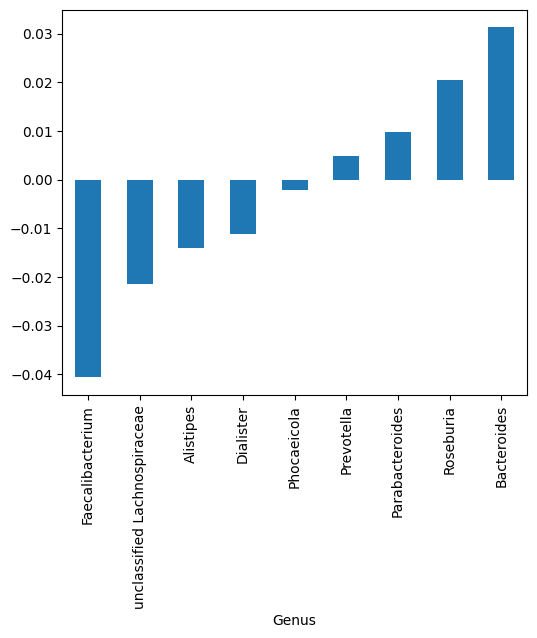

In [38]:
get_delta(tmp,"Genus").sort_values().plot.bar(figsize = (6,5))
plt.savefig("./figures/3.7.2.GenusDeltaRelativeAbundances.svg",format="SVG")